In [1]:
#pip install efficientnet

In [2]:
import numpy as np
import os
import pandas as pd
import kaggle
import matplotlib.pyplot as plt
import tensorflow as tf, tensorflow.keras.backend as K
import seaborn as sns
import random
import efficientnet.tfkeras as efn
import cv2
from tensorflow.keras import optimizers
import hashlib
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed=13):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_KERAS'] = '1'
    random.seed(seed)

seed_everything(42)

In [4]:
def TPU():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print("Running on tpu", tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy()
    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return strategy

strategy = TPU()

REPLICAS:  1


In [5]:
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
IMAGE_H = 512
IMAGE_W = 512
FOLDS = 5
SEED = 42
EPOCHS = 50
BATCH_SIZE = 8*strategy.num_replicas_in_sync

In [7]:
path = "A:/Programming/Python/NLP/Data files/Plant Pathology Project/plant-pathology-2020-fgvc7/"

train = pd.read_csv(path + "train.csv")
# for i in range(20):
#     print(train[i])
print(train.shape)


(1821, 5)


In [8]:
train_id = train['image_id']

In [9]:
for i in train_id:
    print(i)

Train_0
Train_1
Train_2
Train_3
Train_4
Train_5
Train_6
Train_7
Train_8
Train_9
Train_10
Train_11
Train_12
Train_13
Train_14
Train_15
Train_16
Train_17
Train_18
Train_19
Train_20
Train_21
Train_22
Train_23
Train_24
Train_25
Train_26
Train_27
Train_28
Train_29
Train_30
Train_31
Train_32
Train_33
Train_34
Train_35
Train_36
Train_37
Train_38
Train_39
Train_40
Train_41
Train_42
Train_43
Train_44
Train_45
Train_46
Train_47
Train_48
Train_49
Train_50
Train_51
Train_52
Train_53
Train_54
Train_55
Train_56
Train_57
Train_58
Train_59
Train_60
Train_61
Train_62
Train_63
Train_64
Train_65
Train_66
Train_67
Train_68
Train_69
Train_70
Train_71
Train_72
Train_73
Train_74
Train_75
Train_76
Train_77
Train_78
Train_79
Train_80
Train_81
Train_82
Train_83
Train_84
Train_85
Train_86
Train_87
Train_88
Train_89
Train_90
Train_91
Train_92
Train_93
Train_94
Train_95
Train_96
Train_97
Train_98
Train_99
Train_100
Train_101
Train_102
Train_103
Train_104
Train_105
Train_106
Train_107
Train_108
Train_109
Train_110


In [10]:
train.pop("image_id")

0          Train_0
1          Train_1
2          Train_2
3          Train_3
4          Train_4
           ...    
1816    Train_1816
1817    Train_1817
1818    Train_1818
1819    Train_1819
1820    Train_1820
Name: image_id, Length: 1821, dtype: object

In [11]:
y_train = train.to_numpy().astype("float32")

In [12]:
category_names = ['healthy','multiple_diseases','rust','scab']
root = 'images'

images_id = [(os.path.join(path, root, idee)) for idee in train_id]

In [13]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

cols = list(train_df.columns[1:])

train_ids = train_df['image_id']
train_images = train_ids.apply(lambda x: path+'images'+x+'.jpg')
test_ids = test_df['image_id']
test_images = test_ids.apply(lambda x: path+'images'+x+'.jpg')

train_labels = train_df.iloc[:,1:].values

In [14]:
#EDA

In [17]:
len(train_df), len(test_df)

(1821, 1821)

In [19]:
print(cols)

['healthy', 'multiple_diseases', 'rust', 'scab']


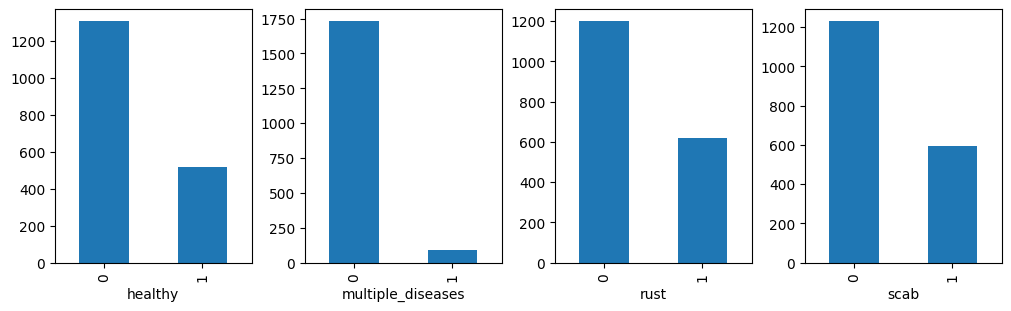

In [20]:
_, ax = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))

for column, ax in zip(cols, ax):
    train_df[column].value_counts().plot.bar(ax=ax)

plt.show()

<Axes: title={'center': 'Label distribution'}>

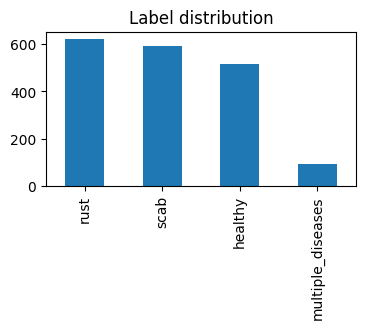

In [25]:
plt.title("Label distribution")
train_df[cols].idxmax(axis=1).value_counts().plot.bar(figsize=(4, 2))

In [35]:
train_df.iloc[:,1:]

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
1816,0,0,0,1
1817,1,0,0,0
1818,1,0,0,0
1819,0,0,1,0
